In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer
from pandas.api.types import CategoricalDtype
from time import perf_counter
from xgboost import XGBRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [15]:
%matplotlib inline
sns.set_theme()

## Loding Data

Load the full car datset. Keep only a subset of columns useful for prediction.
Drop samples with key features missing (mileage, age, price, power). Split the df in train and test. 

In [2]:
file_path = os.path.join("data", "autoscout_dataset.csv")
df_raw = pd.read_csv(file_path, sep=";", index_col="url")

In [3]:
final_col = ['Carburante',
                 'Carrozzeria',
                 'Chilometraggio',
                 'Cilindrata_cm3',
                 'Cilindri',
                 'Colore',
                 'Consumo_comb_L100km',
                 'Consumo_extraurb_L100km',
                 'Consumo_urb_L100km',
                 'Marce',
                 'Peso_a_vuoto_kg',
                 'Tagliandi_certificati',
                 'Tipo_di_cambio',
                 'Trazione',
                 'country',
                 'makeId',
                 'maker',
                 'model',
                 'modelOrModelLineId',
                 'potenza_kw',
                 'price',
                 'unico_proprietario',
                 'zip'
            ]

In [4]:
df_raw = (df_raw.astype({'Anno':'datetime64[ns]', 'date':'datetime64[ns]'})
    .assign(age_years= lambda x: (x['date'] - x['Anno']) / np.timedelta64(1, 'Y'))
    .drop(columns=[col for col in df_raw.columns if col not in final_col])
    .dropna(subset=['price', 'potenza_kw', 'age_years', 'Chilometraggio'])
)
    

In [5]:
df_train, df_test = train_test_split(df_raw, test_size=0.1)

## Loss Functions

In [32]:
def rmse_loss(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def rmspe_loss(y_true, y_pred):
    return np.mean((y_true-y_pred)**2/y_true**2)**0.5

def mape_loss(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred)/y_true)

rmse = make_scorer(rmse_loss, greater_is_better=False)
mae = make_scorer(mean_absolute_error, greater_is_better=False)
rmspe = make_scorer(rmspe_loss, greater_is_better=False)
mape = make_scorer(mape_loss, greater_is_better=False)

## Baseline

Most simple baseline: using the mean/median as prediciton

In [38]:
price_mean = float(df_train['price'].mean())
price_median = float(df_train['price'].median())

rmse_mean = rmse_loss(df_test['price'].to_numpy(), np.ones(len(df_test))*price_mean)
mae_median = mean_absolute_error(df_test['price'].to_numpy(), np.ones(len(df_test))*price_median)

print(f'Baseline (mean/rms): {rmse_mean:.0f}')
print(f'Baseline (median/mae): {mae_median:.0f}')

Baseline (mean/rms): 152239
Baseline (median/mae): 13383


## Linear Models

In [8]:
lm_num_features = ['age_years', 'potenza_kw', 'Chilometraggio']
lm_cat_features = ['Tipo_di_cambio', 'Trazione', 'Carrozzeria']

In [9]:
#Numerical features pipeline
lm_num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


#Categorical features pipeline
lm_cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

# Preprocessing pipeline
lm_preprocessor = make_column_transformer(
    (lm_num_transformer, lm_num_features),
    (lm_cat_transformer, lm_cat_features),
    remainder='drop'
)


# Full model pipeline
lm_model = make_pipeline(
    lm_preprocessor,
    LinearRegression()    
)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['price']), df_train['price'], test_size=0.2, random_state=42
)

In [11]:
lm_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                 

In [41]:
print(f'rmse lmcat train: {rmse_loss(y_train, lm_model.predict(X_train)):.0f}')
print(f'rmse lmcat test: {rmse_loss(y_test, lm_model.predict(X_test)):.0f}')

rmse lmcat train: 21943
rmse lmcat test: 107951


In [42]:
print(f'mape lmcat train: {mape_loss(y_train, lm_model.predict(X_train))*100:.1f}')
print(f'mape lmcat test: {mape_loss(y_test, lm_model.predict(X_test))*100:.1f}')

mape lmcat train: 254.7
mape lmcat test: 46.5


(-100000.0, 100000.0)

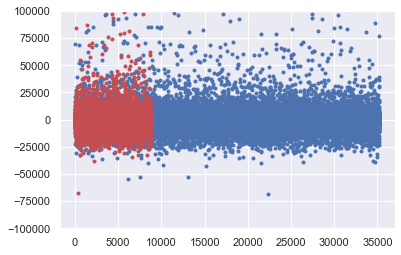

In [16]:
plt.plot((y_train-lm_model.predict(X_train)).to_numpy(), 'b.')
plt.plot((y_test-lm_model.predict(X_test)).to_numpy(), 'r.')
plt.ylim(-1e5, 1e5)

## Random Forest Model

In [18]:
rf_num_features = ['age_years', 'potenza_kw', 'Chilometraggio']
rf_cat_features = ['Tipo_di_cambio', 'Trazione', 'Carrozzeria']

In [19]:
#Numerical features pipeline
rf_num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


#Categorical features pipeline
rf_cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

# Preprocessing pipeline
rf_preprocessor = make_column_transformer(
    (rf_num_transformer, rf_num_features),
    (rf_cat_transformer, rf_cat_features),
    remainder='drop'
)


# Full model pipeline
rf_model = make_pipeline(
    rf_preprocessor,
    RandomForestRegressor()    
)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['price']), df_train['price'], test_size=0.2, random_state=42
)

In [21]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                 

In [43]:
print(f'rmse rf train: {rmse_loss(y_train, rf_model.predict(X_train)):.0f}')
print(f'rmse rf test: {rmse_loss(y_test, rf_model.predict(X_test)):.0f}')

rmse rf train: 7596
rmse rf test: 107080


In [44]:
print(f'mape rf train: {mape_loss(y_train, rf_model.predict(X_train))*100:.1f}')
print(f'mape rf test: {mape_loss(y_test, rf_model.predict(X_test))*100:.1f}')

mape rf train: 76.9
mape rf test: 18.1


## XGB Model

In [27]:
# Full model pipeline
xg_model = make_pipeline(
    rf_preprocessor,
    XGBRegressor()    
)

In [28]:
xg_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                 

In [45]:
print(f'rmse xg train: {rmse_loss(y_train, xg_model.predict(X_train)):.0f}')
print(f'rmse xg test: {rmse_loss(y_test, xg_model.predict(X_test)):.0f}')

rmse xg train: 4255
rmse xg test: 108123


In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:.0f}'.format):
    display(df_raw.groupby('maker')['price'].apply(np.mean).sort_values(ascending=False).to_frame().T)

maker,Lamborghini,McLaren,Ferrari,Rolls-Royce,Aston Martin,Porsche,Lotus,Alpine,Bentley,Caterham,Austin-Healey,Morgan,Maserati,HUMMER,RAM,Tesla,Corvette,Land Rover,Puch,Buick,Maxus,Cupra,Lynk \u0026 Co,Triumph,Jaguar,Audi,Lexus,Daimler,Mercedes-Benz,Dodge,BMW,DS Automobiles,Jeep,Volvo,MG,Alfa Romeo,Abarth,Isuzu,Oldtimer,Ford,Altro,Volkswagen,Renault,Skoda,MINI,Subaru,Infiniti,Mazda,Austin,Nissan,GMC,DR Motor,Lincoln,Iveco,EVO,Peugeot,SEAT,Cadillac,Kia,Toyota,Honda,Hyundai,Suzuki,XEV,Panther Westwinds,SsangYong,Mitsubishi,Lada,Dacia,Citroen,Fiat,Opel,Great Wall,Mahindra,smart,Rover,Giotti Victoria,Lancia,Chevrolet,Tazzari EV,VEM,Ligier,Piaggio,UAZ,Autobianchi,Aixam,Dutton,Chatenet,Casalini,Tata,Saab,Chrysler,Innocenti,Daihatsu,Microcar,Talbot,DAF,Grecav,Daewoo
price,278735,227400,208102,190300,124091,80221,68413,61000,59616,58000,57300,55000,54628,49992,49000,47620,44900,39681,38000,37000,36222,35447,34084,33375,32404,31865,30461,29980,29880,28273,28088,25740,25428,24843,24836,23383,22304,21201,20960,20404,20043,19395,19307,18930,18872,18544,18442,18259,18175,18122,18000,17805,17400,17132,16991,16781,16749,16710,16682,16186,15769,15529,15235,15190,15000,14803,14231,14000,13433,13424,13340,13297,12946,12542,12316,12267,11833,11059,10340,10000,9990,9833,9246,9200,9073,9005,9000,8433,7767,6786,6635,6623,6587,6500,6500,5900,4250,3000,1496
